# Build an agent with LangGraph

By themselves, LLMs cannot take **actions** - they just output text. Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs to pass them. After executing actions, the results can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish.

In this notebook, we will build an agent in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

> The code in this notebook is adapted from [Introduction to LangGraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/).


## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")
assert os.environ.get("TAVILY_API_KEY")

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, we will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've defined our `State` as a TypedDict with a single key: `messages`. The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular Python functions.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns an updated `messages` list. This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [4]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [5]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [6]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

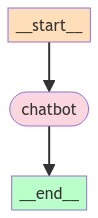

In [7]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Now let's run the chatbot! 

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [8]:
while True:    
    
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User:  What is the weather in Kuala Lumpur?


Assistant: I do not have access to real-time information, including weather. To get the current weather in Kuala Lumpur, I recommend checking a reliable weather website or app. 

Here are some popular options:

* **AccuWeather:** [https://www.accuweather.com/](https://www.accuweather.com/)
* **The Weather Channel:** [https://weather.com/](https://weather.com/)
* **Weather Underground:** [https://www.wunderground.com/](https://www.wunderground.com/)
* **Google Weather:** [https://www.google.com/search?q=weather+kuala+lumpur](https://www.google.com/search?q=weather+kuala+lumpur) 



User:  exit


Goodbye!


**Congratulations!** We've built our first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM.

However, the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the chatbot's knowledge and make it more capable.

Below is the full code for this section:

In [9]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be 
# called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool [Tavily Search API](https://tavily.com/). Our chatbot can use this tool to find relevant information and provide better responses.

See also: [LangChain tools - Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tool.invoke("What is the weather in Kuala Lumpur?")

[{'url': 'https://www.meteoprog.com/weather/Kualalumpur/month/june/',
  'content': 'Kuala Lumpur (Malaysia) weather in June 2024 ☀️ Accurate weather forecast for Kuala Lumpur in June ⛅ Detailed forecast By month Current temperature "near me" Weather news ⊳ Widget of weather ⊳ Water temperature | METEOPROG. Meteoprog.com. ... 25 June +32 °+24° 26 June +32° ...'},
 {'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Kuala Lumpur', 'region': 'Kuala Lumpur', 'country': 'Malaysia', 'lat': 3.17, 'lon': 101.7, 'tz_id': 'Asia/Kuala_Lumpur', 'localtime_epoch': 1719286876, 'localtime': '2024-06-25 11:41'}, 'current': {'last_updated_epoch': 1719286200, 'last_updated': '2024-06-25 11:30', 'temp_c': 30.0, 'temp_f': 86.1, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.9, 'wind_kph': 4.7, 'wind_degree': 172, 'wind_dir': 'S', 'pressure_mb': 1009.0, 'pressure_in': 29.8, 'precip_mm': 0.0, 'precip_

The results are page summaries our chat bot can use to answer questions.

Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [11]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Modification: tell the LLM which tools it can call
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, implement a `BasicToolNode` class that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

Later, we will replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is helpful to see what is going on under the hood.

In [12]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):        
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
            
        outputs = []
        
        for tool_call in message.tool_calls:
            tool_name = tool_call["name"]
            tool = self.tools_by_name[tool_name]
            tool_args = tool_call["args"]
            tool_result = tool.invoke(tool_args)
                        
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_name,
                    tool_call_id=tool_call["id"],
                )
            )
            
        return {"messages": outputs}


In [13]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`. 

Recall that **edges** route the control flow from one node to the next. **Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called `route_tools`, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next. 

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, but implementing it ourselves first makes things more clear. 

In [17]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
        
    if (hasattr(ai_message, "tool_calls") and 
        len(ai_message.tool_calls) > 0):        
        return "tools"        
    return "__end__"


In [18]:
# The `route_tools` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    
    # The following dictionary lets you tell the graph to interpret 
    # the condition's outputs as a specific node.
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {
        "tools": "tools", 
        "__end__": "__end__"
    },
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [19]:
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the '`chatbot`' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly. 

Like the prebuilt `tools_condition`, our function returns the "`__end__`" string if no tool calls are made. When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution. Because the condition can return `__end__`, we don't need to explicitly set a `finish_point` this time. Our graph already has a way to finish!

Let's visualize the graph we've built.

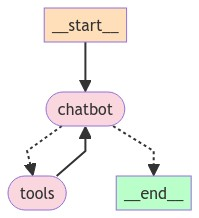

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Now we can ask the bot questions outside its training data.

In [21]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
        
    for event in graph.stream(
        {
            "messages": [("user", user_input)]
        }
    ):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  What is the weather in Kuala Lumpur?


Assistant: 
Assistant: [{"url": "https://www.meteoprog.com/weather/Kualalumpur/month/june/", "content": "Kuala Lumpur (Malaysia) weather in June 2024 \u2600\ufe0f Accurate weather forecast for Kuala Lumpur in June \u26c5 Detailed forecast By month Current temperature \"near me\" Weather news \u22b3 Widget of weather \u22b3 Water temperature | METEOPROG ... 25 June +32 \u00b0+24\u00b0 26 June +32\u00b0 ..."}, {"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Kuala Lumpur', 'region': 'Kuala Lumpur', 'country': 'Malaysia', 'lat': 3.17, 'lon': 101.7, 'tz_id': 'Asia/Kuala_Lumpur', 'localtime_epoch': 1719287567, 'localtime': '2024-06-25 11:52'}, 'current': {'last_updated_epoch': 1719287100, 'last_updated': '2024-06-25 11:45', 'temp_c': 30.0, 'temp_f': 86.1, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.9, 'wind_kph': 4.7, 'wind_degree': 172, 'wind_dir': 'S', 'pressure_mb': 1009.0, 'pr

User:  Will it rain there today?


Assistant: I am sorry, I cannot fulfill this request. The available tools lack the functionality to provide weather information. 



User:  exit


Goodbye!


**Congrats!** We've created a conversational agent in LangGraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries.

Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add **memory** to address this.

The full code for the graph we've created in this section is reproduced below, replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode), and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [22]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off. 

To get started, create a `SqliteSaver` checkpointer:

In [23]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Notice** that we've specified `:memory` as the Sqlite DB path. This is convenient for our notebook (it saves it all in-memory). In a production application, you would likely change this to connect to your own DB and/or use one of the other checkpointer classes.

Next define the graph. Now that you've already built your own `BasicToolNode`, we'll replace it with LangGraph's prebuilt `ToolNode` and `tools_condition`, since these do some nice things like parallel API execution. Apart from that, the following is all copied from Part 2.

In [24]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [25]:
graph = graph_builder.compile(checkpointer=memory)

Notice the graph hasn't changed since Part 2. All we are doing is checkpointing the `State` as the graph works through each node.

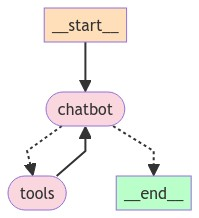

In [27]:
from IPython.display import Image, display

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

Now we can interact with our bot! First, pick a thread to use as the key for this conversation.

In [28]:
config = {"configurable": {"thread_id": "1"}}

Next, call our chat bot.

In [29]:
user_input = "Hi there! My name is Ken."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Ken.
================================== Ai Message ==================================

Hi Ken, nice to meet you! 👋  What can I do for you today?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [30]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input = {
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Ken! 😊  Is there anything else I can help you with?


**Notice** that we aren't using an external list for memory – it's all handled by the checkpointer!

Try using a different `thread_id` in the `config` argument and see if it remembers your name:

In [31]:
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    },
    config={
        "configurable": {
            # Only difference is we change the `thread_id` 
            # to "2" instead of "1"
            "thread_id": "2"
        }
    },
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. If you would like to tell me your name, I can remember it for this conversation. What is your name?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config.

By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [32]:
snapshot = graph.get_state(config) # config for thread_id = 1
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Ken.', id='efa2a6d6-d140-48d6-9604-b42d6adc0df2'), AIMessage(content='Hi Ken, nice to meet you! 👋  What can I do for you today? \n', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-bad3872b-e569-41b6-a2fa-92b9b2131f92-0', usage_metadata={'input_tokens': 82, 'output_tokens': 18, 'total_tokens': 100}), HumanMessage(content='Remember my name?', id='ed4c40a7-4bb1-40e2-8fc5-853822f17005'), AIMessage(content='I will try my best to remember your name, Ken! 😊  Is ther

In [34]:
# Since the graph ended this turn, `next` is empty. 
# If you fetch a state from within a graph invocation, 
# next tells which node will execute next.
snapshot.next

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `__end__` state, so `next` is empty.

**Congratulations!** Our chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

In the next part, we'll introduce human oversight to our bot to handle situations where it may need guidance or verification before proceeding.
  
Check out the code snippet below to review our graph from this section:

In [35]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory)

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before executing to ensure that everything is working as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break at the tool node.

First, start from our existing code. The following is copied from Part 3.

In [43]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ]
    }


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

Now, compile the graph, specifying to `interrupt_before` the `action` node.

In [44]:
memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(
    checkpointer=memory,    
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)

In [45]:
user_input = "What is the weather in Kuala Lumpur?"
config = {
    "configurable": {"thread_id": "1"}
}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    input={
        "messages": [("user", user_input)]
    }, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in Kuala Lumpur?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2ea85c39-bb4c-4978-a2ee-54c21e426fd5)
 Call ID: 2ea85c39-bb4c-4978-a2ee-54c21e426fd5
  Args:
    query: weather in Kuala Lumpur


Let's inspect the graph state to confirm it worked.

In [46]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice** the `next` node is set to **`tools`**. We've interrupted it **before** the `tools` node! Let's check the tool invocation.

In [47]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Kuala Lumpur'},
  'id': '2ea85c39-bb4c-4978-a2ee-54c21e426fd5'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [48]:
# `None` will append nothing new to the current state, letting it 
# resume as if it had never been interrupted.
events = graph.stream(
    input=None, 
    config=config, 
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.met.gov.my/en/forecast/weather/town/", "content": "Location : Kuala Lumpur. Date Weather Forecast; 20/06/2024 Thursday Thunderstorms Morning: Thunderstorms Afternoon: Thunderstorms Night: No rain Min: 24 ... 25/06/2024 Tuesday Thunderstorms Morning: Thunderstorms Afternoon: No rain Night: No rain Min: 24\u00b0C Max: 34\u00b0C"}, {"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Kuala Lumpur', 'region': 'Kuala Lumpur', 'country': 'Malaysia', 'lat': 3.17, 'lon': 101.7, 'tz_id': 'Asia/Kuala_Lumpur', 'localtime_epoch': 1719295963, 'localtime': '2024-06-25 14:12'}, 'current': {'last_updated_epoch': 1719295200, 'last_updated': '2024-06-25 14:00', 'temp_c': 32.7, 'temp_f': 90.8, 'is_day': 1, 'condition': {'text': 'Patchy rain nearby', 'icon': '//cdn.weatherapi.com/weather/64x64/day/176.png', 'code': 1063}, 'wind_mph': 4.9, 'wind_kph':

**Congrats!** We've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

Below is a copy of the code you used in this section. The only difference between this and the previous parts is the addition of the `interrupt_before` argument.

In [49]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(state_schema=State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node(node="chatbot", action=chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node(node="tools", action=tool_node)

graph_builder.add_conditional_edges(
    source="chatbot",
    path=tools_condition,
)
graph_builder.add_edge(
    start_key="tools", 
    end_key="chatbot"
)
graph_builder.set_entry_point(key="chatbot")

memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(
    checkpointer=memory,
    
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["tools"]
)